Detecting Spam Emails Using Tensorflow in Python

Importing necessary libraries for EDA


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Importing libraries necessary for Model Building and Training


In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

In [27]:
data = pd.read_csv('/content/messages.csv')
data.head()

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


In [28]:
data.shape


(2893, 3)

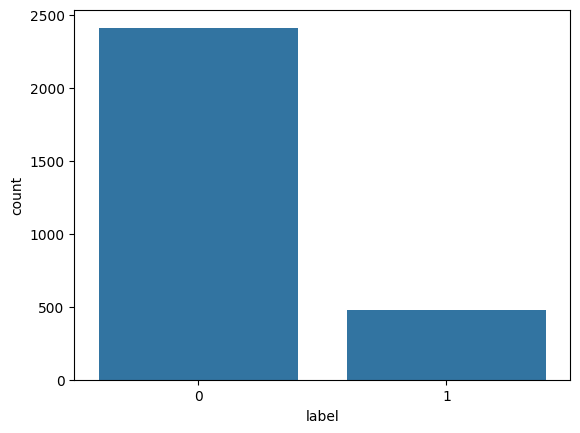

In [30]:
sns.countplot(x='label', data=data)
plt.show()

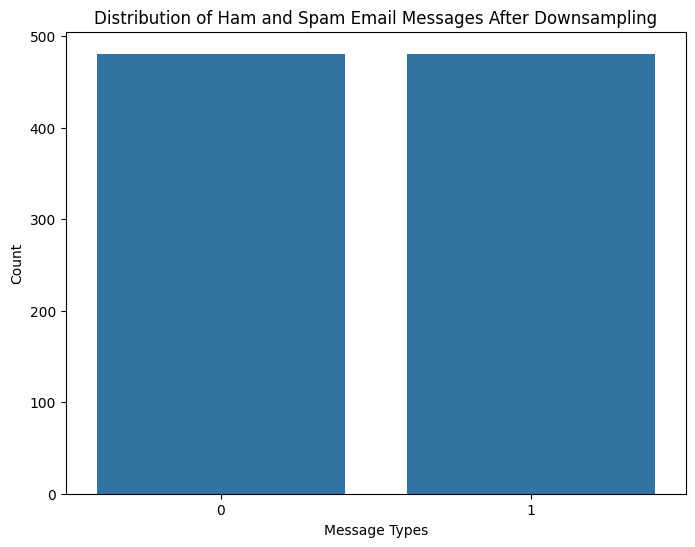

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Downsample ham messages
ham_msg = data[data.label == 0]
spam_msg = data[data.label == 1]

ham_msg = ham_msg.sample(n=len(spam_msg), random_state=42)

# Combine ham and spam data using pd.concat instead of append
balanced_data = pd.concat([ham_msg, spam_msg], axis=0).reset_index(drop=True)

# Plotting the counts of downsampled dataset
plt.figure(figsize=(8, 6))
sns.countplot(data=balanced_data, x='label')
plt.title('Distribution of Ham and Spam Email Messages After Downsampling')
plt.xlabel('Message Types')
plt.ylabel('Count')
plt.show()


Text Preprocessing


Stopwords Removal
Punctuations Removal
Stemming or Lemmatization

In [40]:
balanced_data['message'] = balanced_data['message'].str.replace('Subject', '')
balanced_data.head()

,subject,message,label
0,"lrec - - new event , deadline",adapting lexical and corpus resources to subla...,0
1,important re : 6 . 68 sum : american dialect s...,correction to the annoucements about american ...,0
2,case studies needed,"dear colleagues , i ' m preparing to teach an ...",0
3,book : english verbs,"author : eugene m . russakovskii , associate p...",0
4,more data on - body / - one,i can't refuse jane anything . here is some mo...,0


In [42]:
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

balanced_data['message']= balanced_data['message'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,subject,message,label
0,"lrec - - new event , deadline",adapting lexical and corpus resources to subla...,0
1,important re : 6 . 68 sum : american dialect s...,correction to the annoucements about american ...,0
2,case studies needed,dear colleagues i m preparing to teach an in...,0
3,book : english verbs,author eugene m russakovskii associate prof...,0
4,more data on - body / - one,i cant refuse jane anything here is some more...,0


In [43]:
def remove_stopwords(message):
    stop_words = stopwords.words('english')

    imp_words = []

    # Storing the important words
    for word in str(message).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output


balanced_data['message'] = balanced_data['message'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,subject,message,label
0,"lrec - - new event , deadline",adapting lexical corpus resources sublanguages...,0
1,important re : 6 . 68 sum : american dialect s...,correction annoucements american dialect socis...,0
2,case studies needed,dear colleagues preparing teach introductory c...,0
3,book : english verbs,author eugene russakovskii associate professor...,0
4,more data on - body / - one,cant refuse jane anything data british nationa...,0


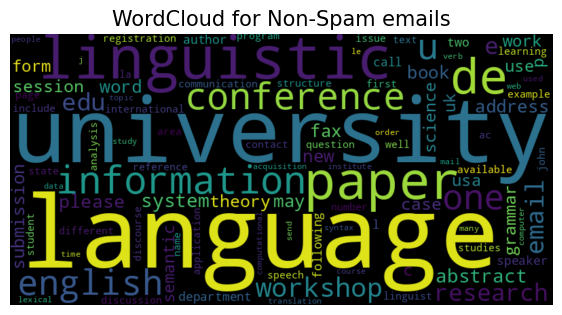

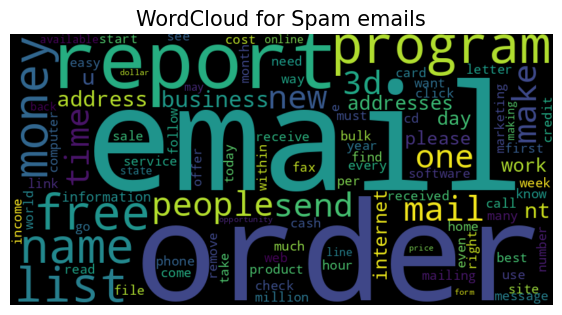

In [44]:
#A word cloud is a text visualization tool that help’s us to get insights into the most frequent
#words present in the corpus of the data.
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['message'])

    plt.figure(figsize=(7, 7))

    wc = WordCloud(background_color='black',
                   max_words=100,
                   width=800,
                   height=400,
                   collocations=False).generate(email_corpus)

    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} emails', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(balanced_data[balanced_data['label'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['label'] == 1], typ='Spam')

In [46]:
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['message'],
                                                    balanced_data['label'],
                                                    test_size = 0.2,
                                                    random_state = 42)

Word2Vec Conversion
We have fitted the tokenizer on our training data we will use it to convert the training and validation data both to vectors


In [47]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100  # maximum sequence length
train_sequences = pad_sequences(train_sequences,
                                maxlen=max_len,
                                padding='post',
                                truncating='post')
test_sequences = pad_sequences(test_sequences,
                               maxlen=max_len,
                               padding='post',
                               truncating='post')

Model Development and Evaluation


In [48]:
# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
                                    output_dim=32,
                                    input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [49]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'],
              optimizer = 'adam')

In [50]:
es = EarlyStopping(patience=3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)

In [51]:
# Train the model
history = model.fit(train_sequences, train_Y,
                    validation_data=(test_sequences, test_Y),
                    epochs=20,
                    batch_size=32,
                    callbacks = [lr, es]
                   )

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.5441 - loss: 0.6925 - val_accuracy: 0.6321 - val_loss: 0.6838 - learning_rate: 0.0010
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6935 - loss: 0.6721 - val_accuracy: 0.8964 - val_loss: 0.5210 - learning_rate: 0.0010
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9541 - loss: 0.3946 - val_accuracy: 0.9585 - val_loss: 0.2052 - learning_rate: 0.0010
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9796 - loss: 0.1481 - val_accuracy: 0.9689 - val_loss: 0.1322 - learning_rate: 0.0010
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.9645 - loss: 0.1491 - val_accuracy: 0.9482 - val_loss: 0.1836 - learning_rate: 0.0010
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9347 - loss: 0.2293 - val_accuracy: 0.9637 - val_loss: 0.1595 - learning_rate: 0.0010
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9798 - loss: 0.1247 - val_acc

In [52]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9589 - loss: 0.1577 
Test Loss : 0.1321689486503601
Test Accuracy : 0.9689119458198547


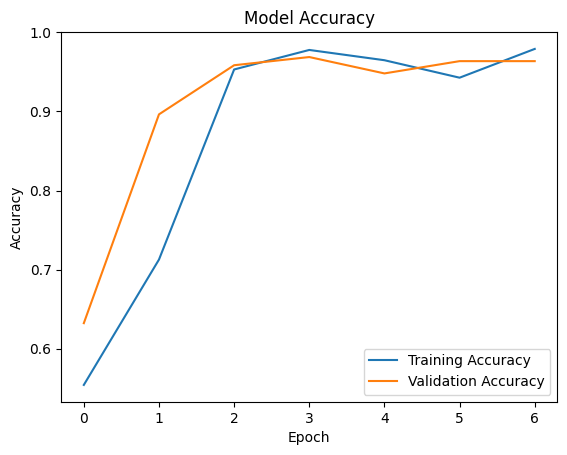

In [53]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()